# classifier.predict_proba not created in PEAClassifier

In [58]:
# Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split, KFold, cross_validate
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedShuffleSplit
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.utils import shuffle
from collections import Counter

#Synthetic data
from imblearn.datasets import make_imbalance
from imblearn.combine import SMOTETomek, SMOTEENN # oversampling and undersampling
from imblearn.over_sampling import SMOTE, ADASYN # oversampling minorityclass
from imblearn.over_sampling import RandomOverSampler

# Helper file
import helper_data_generator

# Models
from PEA1 import PerformanceEnrichmentAnalysisClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier

# Metric
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, precision_score, \
recall_score, SCORERS, roc_auc_score, roc_curve, auc, precision_recall_curve, classification_report

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
classifier_list = [
     PerformanceEnrichmentAnalysisClassifier(
        number_of_clusters=20, permutations=100),
     KNeighborsClassifier(3),
     SVC(kernel="linear", C=0.025),
     # SVC(gamma=2, C=1),
     DecisionTreeClassifier(max_depth=5),
     # RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
     # MLPClassifier(alpha=0.01),
     AdaBoostClassifier(),
     # GaussianNB(),
     # QuadraticDiscriminantAnalysis()
]

In [4]:
def get_PEA_data():
    '''
    Return: Stratified X_train, X_test, y_train, y_test from PEA Dataset
    
    '''
    df = pd.read_csv('../../data/pea_data_2018-08-28_cleaned.csv', sep=';', decimal=',')

    X_full = df.loc[:, ['order_weight_aim',
                    'width',
                    'thickness',
                    'piece_weight_aim',
                    "productionsteps"]].reset_index(drop=True)
    y_full = df.loc[:,'lateness']

    borders = [-2880, 2880]

    (y_full_encoded_values, Y_full_encoded_class_labels) =  helper_data_generator.encode_target_features_to_categorical(y_full, borders)
        
    return X_full, y_full_encoded_values


def get_synthetic_data(noise, cluster_per_class, class_separator):
    '''
    
    n_samples=5000,
    n_features=26,
    n_informative=21,
    n_redundant=5,
    n_repeated=0,
    n_classes=3,
    n_clusters_per_class=5,
    class_sep=0.9,
    flip_y=noise,
    weights=[0.65, 0.11, 0.24]
    
    Return: synthetic data from sklearn makeclassifier
    
    '''
    X, y = helper_data_generator.make_classification(n_samples=5000,
                                       n_features=26,
                                       n_informative=21,
                                       n_redundant=5,
                                       n_repeated=0,
                                       n_classes=3,
                                       n_clusters_per_class=cluster_per_class,
                                       class_sep=class_separator,
                                       flip_y=noise,
                                       weights=[0.65, 0.11, 0.24])
    
    return X, y


def get_oversampled_data(algotype):
    '''
    Oversample label:0 in PEA dataset using hyperparams sampling_strategy=not majority and n_neighbors=15
    Input:
        algotype: {'SMOTE', 'ADASYN'}
    '''
    X, y = get_PEA_data()
    
    if algotype=='ADASYN':
        X_resampled, y_resampled = ADASYN(sampling_strategy='not majority', n_neighbors=15).fit_resample(X, y)
        display('ADASYN')
    elif algotype=='SMOTE':
        X_resampled, y_resampled = SMOTE(sampling_strategy='not majority', k_neighbors=15).fit_resample(X, y)
        display('SMOTE')
    
    return X_resampled, y_resampled

def get_oversample_synthetic_data(noise, cluster_per_class, algotype, class_separator):
    
    X, y = get_synthetic_data(noise, cluster_per_class, class_separator)
    
    if algotype=='ADASYN':
        X_resampled, y_resampled = ADASYN(sampling_strategy='not majority', n_neighbors=15).fit_resample(X, y)
        display('ADASYN')
    elif algotype=='SMOTE':
        X_resampled, y_resampled = SMOTE(sampling_strategy='not majority', k_neighbors=15).fit_resample(X, y)
        display('SMOTE')
    
    return X_resampled, y_resampled

In [5]:
def perform_shuffle_split(clf, X, y, num_of_splits, metric=None):
    
    list_of_mean_classwise_auc = [] 
    list_of_mean_classwise_tpr = []
    list_of_mean_classwise_fpr = []
    
    list_auc_A = []
    list_auc_B = []
    list_auc_C = []
        
    list_tpr_A = []
    list_tpr_B = []
    list_tpr_C = []
    
    list_fpr_A = []
    list_fpr_B = []
    list_fpr_C = []
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
    # https://stackoverflow.com/questions/45969390/difference-between-stratifiedkfold-and-stratifiedshufflesplit-in-sklearn/46181361
    
    #skf = StratifiedKFold(n_splits=num_of_splits, shuffle=True)
    ssf = StratifiedShuffleSplit(n_splits=num_of_splits, test_size=0.1)
    for train_index, test_index in ssf.split(X, y):
        
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
#         display(X_train.shape)
#         display(X_test.shape)
#         display(y_train.shape)
#         display(y_test.shape)
        clf.fit(X_train, y_train)
        prediction = clf.predict(X_test)
        
        if metric=='synthetic':
            y_test = label_binarize(y_test, classes=[0,1,2])
            prediction = label_binarize(prediction, classes=[0,1,2])
        else:
            y_test = label_binarize(y_test, classes=[-1,0,1])
            prediction = label_binarize(prediction, classes=[-1,0,1])
        
#         target_names = ['class 0', 'class 1', 'class 2']
#         print(classification_report(y_test, prediction, target_names=target_names))
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        n_classes = y_test.shape[1]
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], prediction[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # for the label=0 where the interpolation returns [0.,1.]
        if len(fpr[1])==2:
            #display(fpr[1])
            b = list(fpr[1]).copy()
            b.insert(1,1.) # insert at index 1
            fpr[1] = np.asarray(b)
            #display(fpr[1])
        
        # for the label=0 where the interpolation returns [0.,1.]
        if len(tpr[1])==2:
            #display(tpr[1])
            b = list(tpr[1]).copy()
            b.insert(1,1.) # insert at index 1
            tpr[1] = np.asarray(b)
            #display(tpr[1])
        
        list_auc_A.append(roc_auc[0])
        list_auc_B.append(roc_auc[1])
        list_auc_C.append(roc_auc[2])    
    
        list_tpr_A.append(fpr[0])
        list_tpr_B.append(fpr[1])
        list_tpr_C.append(fpr[2])
    
        list_fpr_A.append(tpr[0])
        list_fpr_B.append(tpr[1])
        list_fpr_C.append(tpr[2])
        
    list_of_mean_classwise_auc.append([np.mean(list_auc_A),np.mean(list_auc_B),np.mean(list_auc_C)])
    list_of_mean_classwise_fpr.append([np.mean(list_fpr_A, axis=0,keepdims=True),np.mean(list_fpr_B, axis=0,keepdims=True),np.mean(list_fpr_C, axis=0,keepdims=True)])
    list_of_mean_classwise_tpr.append([np.mean(list_tpr_A, axis=0,keepdims=True),np.mean(list_tpr_B, axis=0,keepdims=True),np.mean(list_tpr_C, axis=0,keepdims=True)])
    
    return list_of_mean_classwise_auc, list_of_mean_classwise_tpr, list_of_mean_classwise_fpr

In [78]:
def plot_roc_auc(clf, X, y, num_of_splits, metric=None):
    
    list_of_mean_auc, list_of_mean_classwise_tpr, list_of_mean_classwise_fpr = perform_shuffle_split(clf, X, y, num_of_splits, metric)
    
    plt.figure(figsize=(10,8))
    lw = 2
    colors = cycle(['darkorange', 'lightgreen', 'cornflowerblue'])
    for i, color in zip(range(3), colors):
        plt.plot(list_of_mean_classwise_tpr[0][i][0], list_of_mean_classwise_fpr[0][i][0], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, list_of_mean_auc[0][i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

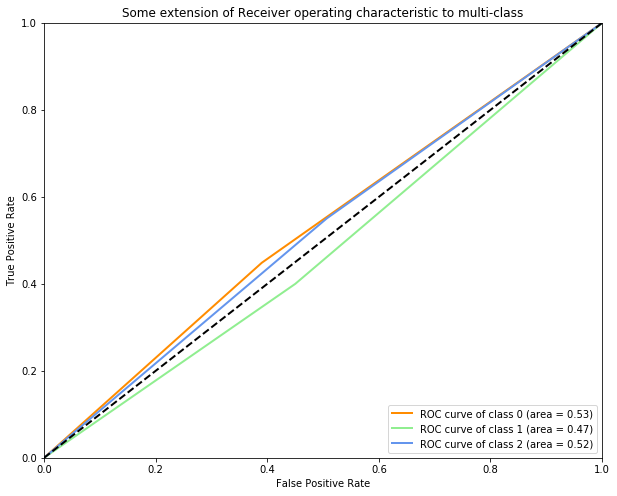

In [83]:
# Plot ROC AUC for PEA Data 
X, y = get_PEA_data()
plot_roc_auc(classifier_list[0], X, y, 10)

'ADASYN'

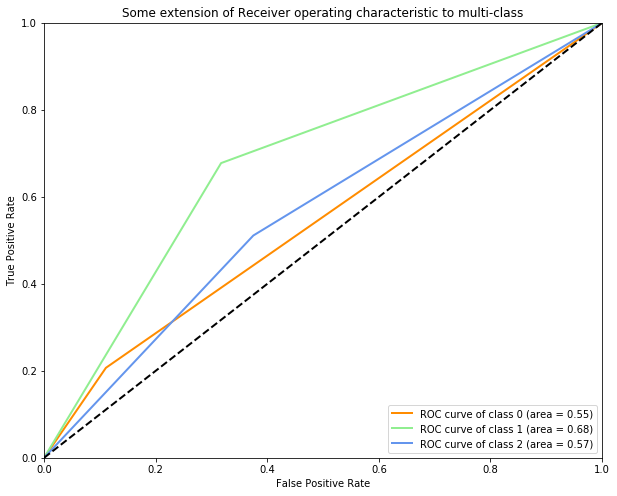

In [82]:
# Plot ROC AUC for PEA Data after oversampling the minority class
X, y = get_oversampled_data('ADASYN')
plot_roc_auc(classifier_list[0], X, y, 10)

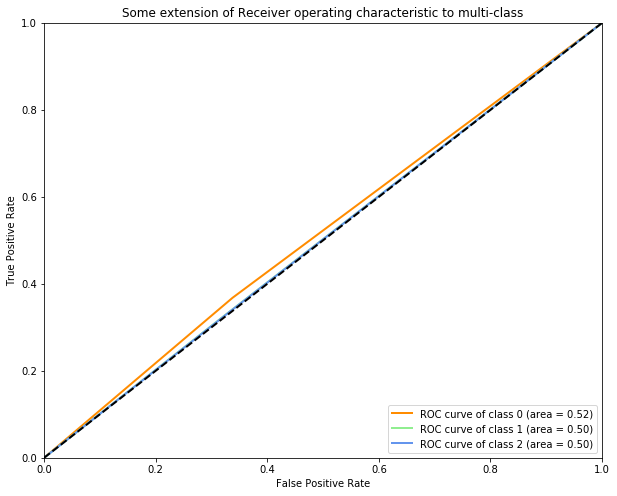

In [59]:
# Plot ROC AUC for synthetic data  without oversampling minority
X, y = get_synthetic_data(noise = 0.6, cluster_per_class = 7, class_separator = 0.8)
X = pd.DataFrame(X)
y = pd.Series(y, name='lateness')
plot_roc_auc(classifier_list[0], X, y, 10, 'synthetic')

'ADASYN'

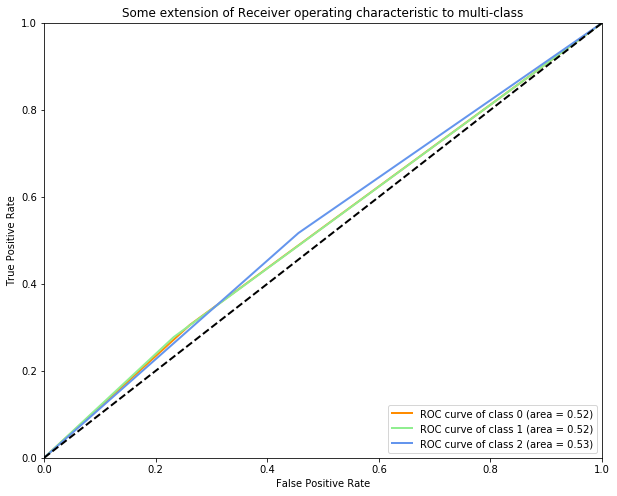

In [60]:
# Plot ROC AUC for synthetic data with oversampling minority
X, y = get_oversample_synthetic_data(noise = 0.6, cluster_per_class = 6, algotype='ADASYN', class_separator=0.6)
X = pd.DataFrame(X)
y = pd.Series(y, name='lateness')
plot_roc_auc(classifier_list[0], X, y, 5, 'synthetic')

'ADASYN'

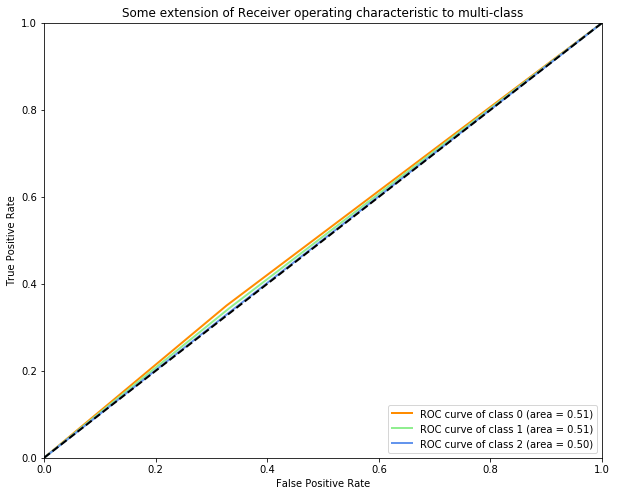

In [65]:
# Plot ROC AUC for PEA Data after oversampling the minority class
X, y = get_oversampled_data('ADASYN')
plot_roc_auc(DummyClassifier(strategy='uniform'), X, y, 10)

'SMOTE'

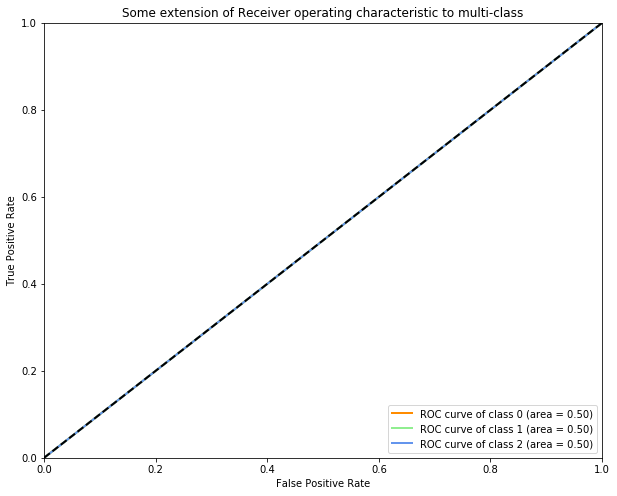

In [71]:
# Plot ROC AUC for PEA Data after oversampling the minority class
X, y = get_oversampled_data('SMOTE')
plot_roc_auc(DummyClassifier(strategy='most_frequent'), X, y, 10)

'ADASYN'

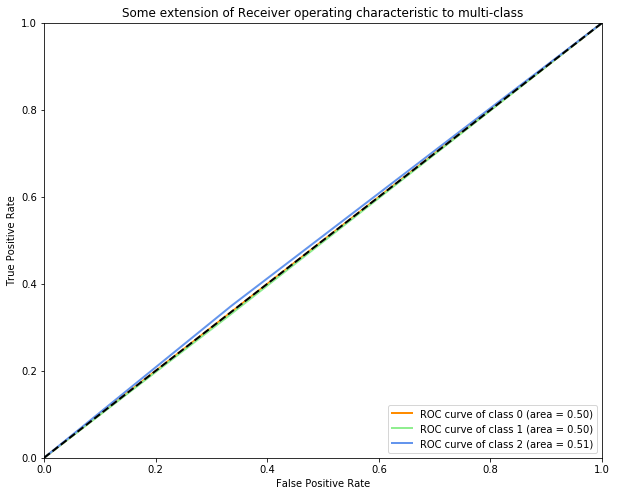

In [77]:
# Plot ROC AUC for PEA Data after oversampling the minority class
X, y = get_oversampled_data('ADASYN')
plot_roc_auc(DummyClassifier(strategy='stratified'), X, y, 10)

In [ ]:
# X, y = process_functionalities(classifier_list[0],'PEA',5,'weighted')
# ros = RandomOverSampler(sampling_strategy='minority')
# X_resampled, y_resampled = ros.fit_resample(X, y)
# from collections import Counter
# print(sorted(Counter(y_resampled).items()))
# plot_roc_auc(classifier_list[0], X_resampled, y_resampled, 5)

# X, y = process_functionalities(classifier_list[0],'PEA',5,'weighted')
# X_resampled, y_resampled = SMOTE(sampling_strategy='not majority', k_neighbors=15).fit_resample(X, y)
# print(sorted(Counter(y_resampled).items()))
# plot_roc_auc(classifier_list[0], X_resampled, y_resampled, 10)

# X, y = process_functionalities(classifier_list[0],'PEA',5,'weighted')
# X_resampled, y_resampled = ADASYN(sampling_strategy='all', n_neighbors=15).fit_resample(X, y)
# print(sorted(Counter(y_resampled).items()))
# plot_roc_auc(classifier_list[0], X_resampled, y_resampled, 10)

# https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-ii-over-sampling-d61b43bc4879
# https://www.ele.uri.edu/faculty/he/PDFfiles/adasyn.pdf
# https://arxiv.org/pdf/1106.1813.pdf
# X, y = process_functionalities(classifier_list[0],'PEA',5,'weighted')
# X_resampled, y_resampled = ADASYN(sampling_strategy='not majority', n_neighbors=15).fit_resample(X, y)
# X_resampled, y_resampled = SMOTE(sampling_strategy='not majority', k_neighbors=15).fit_resample(X, y)
# print(sorted(Counter(y_resampled).items()))
# plot_roc_auc(classifier_list[0], X_resampled, y_resampled, 10)

# X, y = process_functionalities(classifier_list[0],'PEA',5,'weighted')
# smote_enn = SMOTEENN(sampling_strategy='not majority', )
# X_resampled, y_resampled = smote_enn.fit_resample(X, y)
# print(sorted(Counter(y_resampled).items()))
# plot_roc_auc(classifier_list[1], X_resampled, y_resampled, 5)

# X, y = process_functionalities(classifier_list[0],'PEA',5,'weighted')
# smote_tomek = SMOTETomek()
# X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
# print(sorted(Counter(y_resampled).items()))
# plot_roc_auc(classifier_list[1], X_resampled, y_resampled, 5)

# https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/combine/plot_comparison_combine.html#sphx-glr-auto-examples-combine-plot-comparison-combine-py
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
# https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

In [ ]:
# next steps using oversampling minority class in PEA

In [ ]:
# create a synthetic dataset and oversample minority class to confirm the behaviour

In [32]:
# X, y = get_PEA_data()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# classifier_list[1].fit(X_train, y_train)
# prediction = classifier_list[1].predict(X_test)

# y_test = label_binarize(y_test,classes=[-1,0,1])
# prediction = label_binarize(prediction,classes=[-1,0,1])

# display(classifier_list[1].predict(X_test))

# display(Counter(classifier_list[1].predict_proba(X_test)[:,2]))

# plt.hist(classifier_list[1].predict_proba(X_test)[:,0])

# display(classifier_list[1].predict_proba(X_test)[:,1])

# display(classifier_list[1].predict_proba(X_test)[:,2])

In [158]:
# http://mtweb.cs.ucl.ac.uk/mus/lib/python2.6/scikit_learn-0.13.1-py2.6-linux-x86_64.egg/sklearn/multiclass.py
# http://www.psych.mcgill.ca/labs/mogillab/anaconda2/lib/python2.7/site-packages/sklearn/multiclass.py
# https://www.dataquest.io/blog/introduction-to-ensembles/

# def predict_proba(X, prediction):
#     display(X.shape[0])
#     #pred = np.random.rand(X.shape[0], 3)
#     pred = np.array([est.predict_proba(X)[:, 1] for est in estimators).T
#     display(pred)
#     return pred / np.sum(pred, axis=1)[:, np.newaxis]
                     
# def predict_proba(X, prediction):
        
#     all_proba = [np.zeros((X.shape[0], j), dtype=np.float64)
#                      for j in np.atleast_1d(3)]
        
#         #display(prediction)
#     all_proba = prediction
        
#     return all_proba / np.sum(all_proba, axis=0)[:, np.newaxis]

# predict_proba(X_test, prediction)

In [48]:
X, y = get_PEA_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# stratified, uniform, most_frequent
model = DummyClassifier(strategy='uniform').fit(X_train,y_train)
Counter(model.predict(X_test))

Counter({1: 495, -1: 524, 0: 539})

In [56]:
X, y = get_PEA_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = DummyClassifier(strategy='uniform').fit(X_train,y_train)
prediction = model.predict(X_test)

y_test = label_binarize(y_test,classes=[-1,0,1])
prediction = label_binarize(prediction,classes=[-1,0,1])

#display(model.predict(X_test))

display(Counter(model.predict(X_test)))

Counter({0: 513, -1: 531, 1: 514})

In [84]:
X, y = get_PEA_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = DummyClassifier(strategy='most_frequent').fit(X_train,y_train)
prediction = model.predict(X_test)

y_test = label_binarize(y_test,classes=[-1,0,1])
prediction = label_binarize(prediction,classes=[-1,0,1])

#display(model.predict(X_test))

display(Counter(model.predict(X_test)))

Counter({-1: 1558})

In [85]:
X, y = get_PEA_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = DummyClassifier(strategy='stratified').fit(X_train,y_train)
prediction = model.predict(X_test)

y_test = label_binarize(y_test,classes=[-1,0,1])
prediction = label_binarize(prediction,classes=[-1,0,1])

#display(model.predict(X_test))

display(Counter(model.predict(X_test)))

Counter({-1: 1024, 1: 530, 0: 4})